In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/russia-real-estate-20182021/all_v2.csv


In [3]:
import warnings
import gc
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

warnings.filterwarnings("ignore") 

In [245]:
df1=pd.read_csv('/kaggle/input/russia-real-estate-20182021/all_v2.csv')

In [246]:
df1.head()

,price,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
0,6050000,2018-02-19,20:00:21,59.8058,30.3761,2661,1,8,10,3,82.6000,10.8000,1
1,8650000,2018-02-27,12:04:54,55.6838,37.2974,81,3,5,24,2,69.1000,12.0000,1
2,4000000,2018-02-28,15:44:00,56.2953,44.0616,2871,1,5,9,3,66.0000,10.0000,1
3,1850000,2018-03-01,11:24:52,44.9961,39.0748,2843,4,12,16,2,38.0000,5.0000,11
4,5450000,2018-03-01,17:42:43,55.9188,37.9846,81,3,13,14,2,60.0000,10.0000,1


In [247]:
df1.describe()

,price,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
count,5477006.0000,5477006.0000,5477006.0000,5477006.0000,5477006.0000,5477006.0000,5477006.0000,5477006.0000,5477006.0000,5477006.0000,5477006.0000
mean,4422029.0229,54.0383,53.2443,4307.1409,1.9490,6.2145,11.3989,1.7262,53.9182,10.6284,3.9454
std,21507519.1548,4.6228,20.7476,3308.0502,1.0385,4.9574,6.5357,1.0821,33.3529,9.7924,4.5584
min,-2144967296.0000,41.4591,19.8902,3.0000,0.0000,1.0000,1.0000,-2.0000,0.0700,0.0100,1.0000
25%,1950000.0000,53.3777,37.7779,2661.0000,1.0000,2.0000,5.0000,1.0000,38.0000,7.0000,1.0000
50%,2990000.0000,55.1714,43.0677,2922.0000,2.0000,5.0000,10.0000,2.0000,48.0200,9.7000,1.0000
75%,4802000.0000,56.2261,65.6489,6171.0000,3.0000,9.0000,16.0000,2.0000,63.1300,12.7000,11.0000
max,2147483647.0000,71.9804,162.5361,61888.0000,5.0000,39.0000,39.0000,10.0000,7856.0000,9999.0000,11.0000


In [248]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5477006 entries, 0 to 5477005
Data columns (total 13 columns):
 #   Column         Dtype  
---  ------         -----  
 0   price          int64  
 1   date           object 
 2   time           object 
 3   geo_lat        float64
 4   geo_lon        float64
 5   region         int64  
 6   building_type  int64  
 7   level          int64  
 8   levels         int64  
 9   rooms          int64  
 10  area           float64
 11  kitchen_area   float64
 12  object_type    int64  
dtypes: float64(4), int64(7), object(2)
memory usage: 543.2+ MB


In [249]:
REGION_ID = 81  # City of Saint Petersburg 2661, Moscow = 81

MIN_AREA = 20  # Outlier range for floor area
MAX_AREA = 120

MIN_KITCHEN = 6  # Outlier range for kitchen area
MAX_KITCHEN = 30

MIN_PRICE = 1_500_000  # Outlier range for price
MAX_PRICE = 50_000_000

SEED = 15
N_FOLDS = 5

object_type=1

In [250]:
def set_display():
    """Function sets display options for charts and pd.DataFrames.
    """
    # Plots display settings
    plt.style.use('fivethirtyeight')
    plt.rcParams['figure.figsize'] = 12, 8
    plt.rcParams.update({'font.size': 14})
    # DataFrame display settings
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)
    pd.options.display.float_format = '{:.4f}'.format


def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    """Function removes excess columns and enforces
    correct data types.
    :param df: Original DataFrame
    :return: Updated DataFrame
    """
    df.drop('time', axis=1, inplace=True)
    df['date'] = pd.to_datetime(df['date'])
    # Column actually contains -1 and -2 values presumably for studio apartments.
    df['rooms'] = df['rooms'].apply(lambda x: 0 if x < 0 else x)
    df['price'] = df['price'].abs()  # Fix negative values
    # Drop price and area outliers.
    df = df[(df['area'] <= MAX_AREA) & (df['area'] >= MIN_AREA)]
    df = df[(df['price'] <= MAX_PRICE) & (df['price'] >= MIN_PRICE)]
    df = df[df['object_type']==object_type]
    # Fix kitchen area outliers.
    # At first, replace all outliers with 0.
    df.loc[(df['kitchen_area'] >= MAX_KITCHEN) | (df['area'] <= MIN_AREA), 'kitchen_area'] = 0
    # Then calculate kitchen area based on the floor area, except for studios.
    erea_mean, kitchen_mean = df[['area', 'kitchen_area']].quantile(0.5)
    kitchen_share = kitchen_mean / erea_mean
    df.loc[(df['kitchen_area'] == 0) & (df['rooms'] != 0), 'kitchen_area'] = \
        df.loc[(df['kitchen_area'] == 0) & (df['rooms'] != 0), 'area'] * kitchen_share

    return df


def select_region(df: pd.DataFrame) -> pd.DataFrame:
    """Function selects the listings belonging to a specified region.
    :param df: Original DataFrame with all listings
    :return: Filtered DataFrame
    """
    df = df[df['region'] == REGION_ID]
    df.drop('region', axis=1, inplace=True)
    print(f'Selected {len(df)} samples in region {REGION_ID}.')
    return df


def add_features(df: pd.DataFrame) -> pd.DataFrame:
    # Replace "date" with numeric features for year and month.
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df.drop('date', axis=1, inplace=True)
    # Apartment floor in relation to total number of floors.
    df['level_to_levels'] = df['level'] / df['levels']
    # Average size of room in the apartment.
    df['area_to_rooms'] = (df['area'] / df['rooms']).abs()
    # Fix division by zero.
    df.loc[df['area_to_rooms'] == np.inf, 'area_to_rooms'] = \
        df.loc[df['area_to_rooms'] == np.inf, 'area']
    return df


def set_seed(seed=42):
    """Utility function to use for reproducibility.
    :param seed: Random seed
    :return: None
    """
    np.random.seed(seed)
    random.seed(seed)
    # tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

Analysis

In [251]:
set_display()

In [252]:
print(f'Data shape: {df1.shape}')

Data shape: (5477006, 13)


In [253]:
data = df1.pipe(clean_data)
data=data[(data['geo_lon']-37.62148<=0.230) & (-0.230<= data['geo_lon']-37.62148) & (data['geo_lat']-55.75378<=0.163) & (-0.163<=data['geo_lat']-55.75378) & (data['price']>=3500000)]
data.head()

,price,date,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
20,8000000,2018-03-17,55.7389,37.8254,3,1,5,9,2,45.0000,6.0000,1
29,11500000,2018-04-03,55.7989,37.7381,3,1,14,16,3,64.9000,8.0000,1
34,10200000,2018-04-07,55.6553,37.6146,3,2,7,14,2,52.8000,10.0000,1
44,11500000,2018-04-18,55.7013,37.5074,3,1,14,17,1,42.0000,12.0000,1
56,20900000,2018-05-01,55.7308,37.6314,3,3,6,10,3,80.0000,8.2000,1


Features and data types
Categorical features:
Region (numerically encoded geographical area, identifies either a large city like Moscow or Saint Petersburg or a federal region / district)
Building type (numerically encoded type of the building where the apartment is located)
Object type (apartment type, where 1 stands for secondary real estate market, 11 - new building)
Numerical features:
Area (total floor area of the apartment in sq. meters)
Kitchen area (kitchen area in sq. meters)
Rooms (number of rooms in the apartment, -1 stands for studios with open-space layout)
Level (floor the apartment is located on, could be treated as a categorical feature as well)
Levels (total number of storeys in the building)
Geospatial features:
Latitude - geographical coordinate of the preperty
Longitude - geographical coordinate of the preperty
Temporal features:
Date (date the listing was published)
Time (exact time the listing was published)

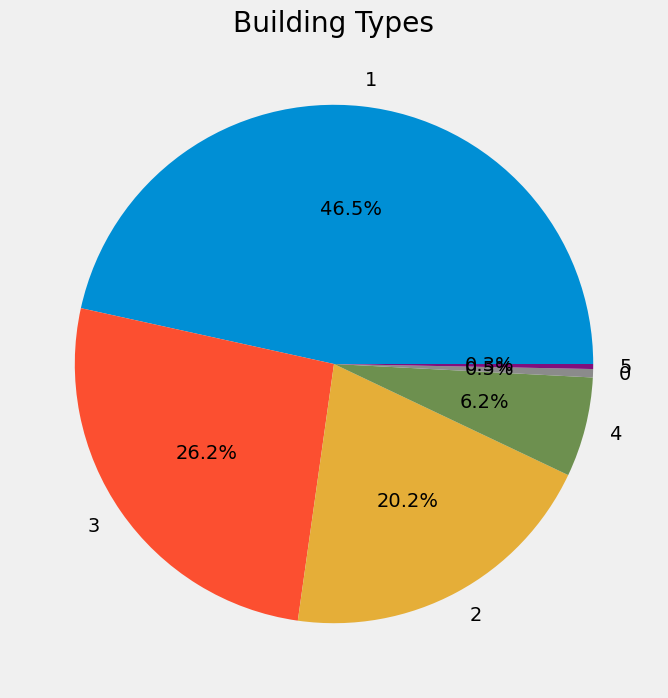

In [254]:
building_types = data['building_type'].value_counts()
plt.pie(building_types.values, labels=building_types.index, autopct='%1.1f%%')
plt.title('Building Types')
plt.show()

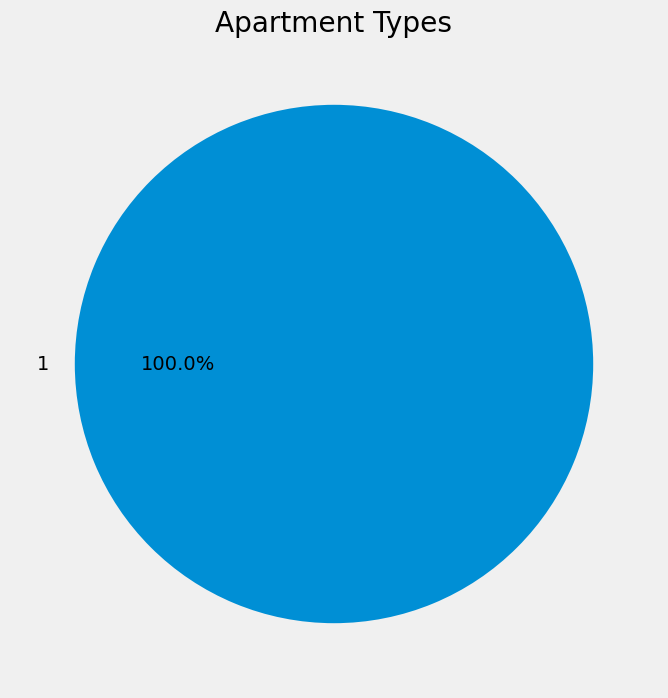

In [255]:
apartment_types = data['object_type'].value_counts()
plt.pie(apartment_types.values, labels=apartment_types.index, autopct='%1.1f%%')
plt.title('Apartment Types')
plt.show()

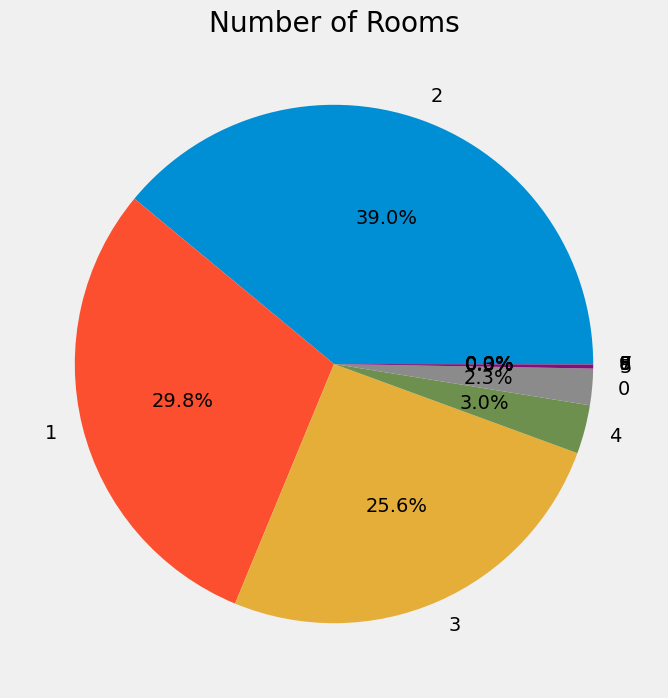

In [256]:
rooms = data['rooms'].value_counts()
plt.pie(rooms.values, labels=rooms.index, autopct='%1.1f%%')
plt.title('Number of Rooms')
plt.show()

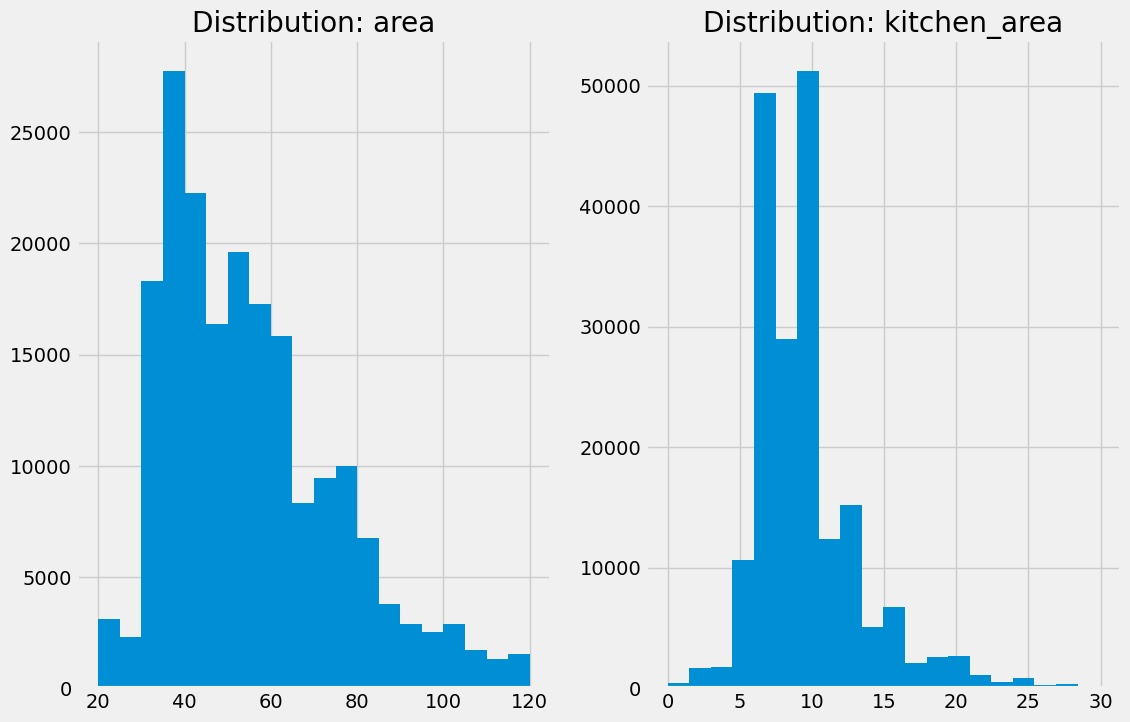

In [257]:
pos = 0
for pos, feature in enumerate(['area', 'kitchen_area']):
    sp = plt.subplot(1, 2, pos + 1)
    plt.hist(data[feature], bins=20)
    plt.title(f'Distribution: {feature}')
plt.show()

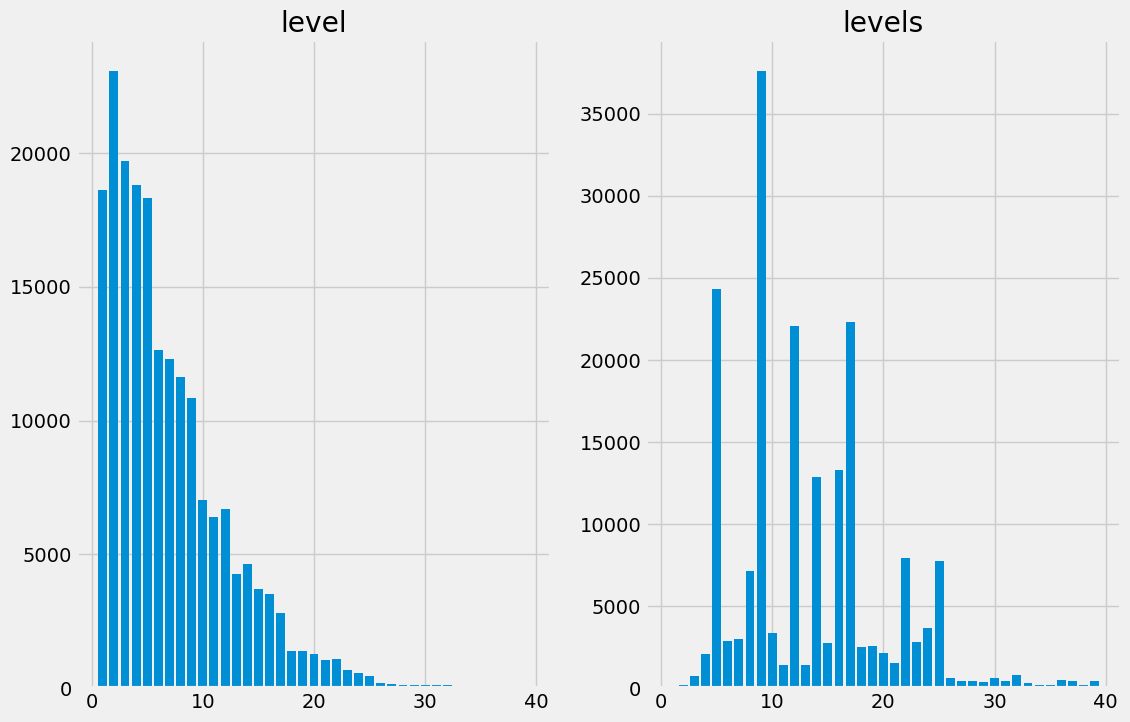

In [258]:
pos = 0
for pos, feature in enumerate(['level', 'levels']):
    levels = data[feature].value_counts()
    sp = plt.subplot(1, 2, pos + 1)
    plt.bar(levels.index, levels.values)
    plt.title(feature)
plt.show()

3     173395
81     20705
Name: region, dtype: int64


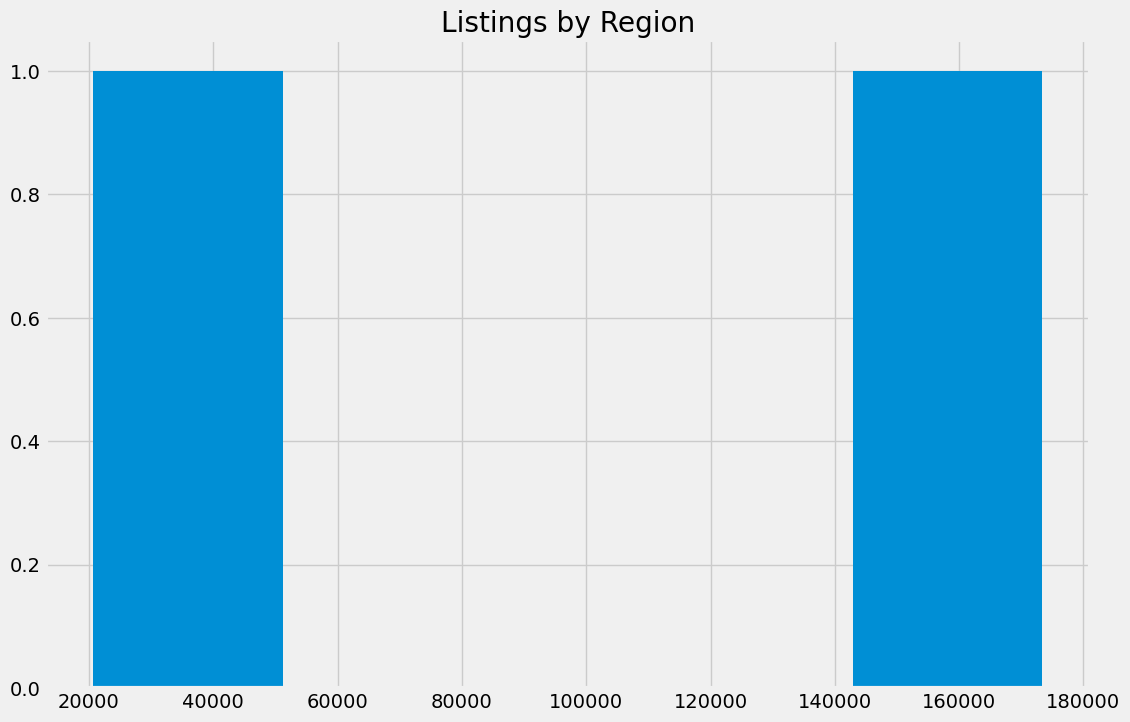

In [259]:
# Regions are encoded with numeric IDs.
regions = data['region'].value_counts()
print(regions.head(10))

plt.hist(regions.values, bins=5)
plt.title('Listings by Region')
plt.show()

Listings are unequally distributed between the regions with most of the offerings concentrated in the largest and most developed cities and their surrounding areas.

In [260]:
# Find out what regions are represented in the data set.
for region in data['region'].unique():
    subset = data[data['region'] == region]
    lat, lon = np.round(subset[['geo_lat', 'geo_lon']].mean(), 2)
    print(f'Region {region}: latitude = {lat}, longitude = {lon}')

Region 3: latitude = 55.75, longitude = 37.61
Region 81: latitude = 55.88, longitude = 37.59


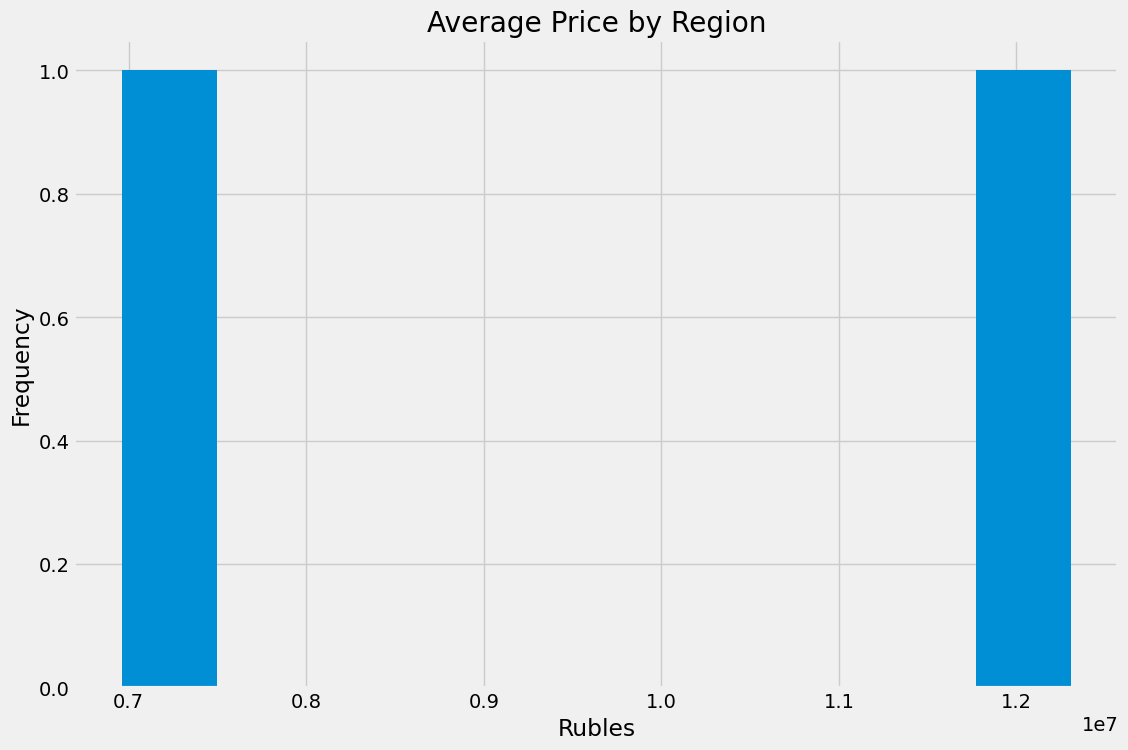

In [261]:
avg_prices = data.groupby(by='region')['price'].mean()
plt.hist(avg_prices.values, bins=10)
plt.xlabel('Rubles')
plt.ylabel('Frequency')
plt.title('Average Price by Region')
plt.show()

Knowing the basics of real estate pricing, it's unreasonable to develop a single model for all the regions. Pricing factors could have different impact on the actual price depending on the region, local market conditions, prevailing types of buildings in the area, etc.

A number of important features are missing in this data set, which would lead to larger errors regardless of applied regression algorithms and quality of the model:

Condition: similar apartments would be priced differently, if one of them is being sold fully furnished in excellent condition and the other is being sold without finishing.
Ceiling height affects the price.
Balconies and terraces increase the price compared to similar apartments without such menities.
Additional unique properties usually mentioned in the description of the apartment, like chimneys or underground parking spaces, affect the price.
Taking that in mind we will try to develop a pricing model for apartments located in Moscow.

Feature Engineering

In [262]:
data = data.pipe(select_region)
data = data.pipe(add_features)
data=data[(data['year']!=2018) | (data['month']!=8)]

data['year'][(data['year']==2018)]=1
data['year'][(data['year']==2019)]=2
data['year'][(data['year']==2020)]=3
data['year'][(data['year']==2021)]=4

data.head()


Selected 20705 samples in region 81.


,price,geo_lat,geo_lon,building_type,level,levels,rooms,area,kitchen_area,object_type,year,month,level_to_levels,area_to_rooms
1469,13690000,55.7605,37.8479,2,10,25,3,108.0000,13.1000,1,1,9,0.4000,36.0000
1476,9500000,55.8837,37.4357,1,20,25,3,84.2000,10.0000,1,1,9,0.8000,28.0667
2111,7000000,55.8915,37.4512,3,25,25,2,65.0000,10.9000,1,1,9,1.0000,32.5000
2173,4150000,55.9050,37.3935,1,22,25,1,40.0000,10.3000,1,1,9,0.8800,40.0000
2425,8700000,55.8892,37.7209,2,12,14,2,77.0000,14.0000,1,1,9,0.8571,38.5000


In [263]:
data.count()

price              20704
geo_lat            20704
geo_lon            20704
building_type      20704
level              20704
levels             20704
rooms              20704
area               20704
kitchen_area       20704
object_type        20704
year               20704
month              20704
level_to_levels    20704
area_to_rooms      20704
dtype: int64

In [264]:
gc.collect()

95960

In [265]:
data.describe()

,price,geo_lat,geo_lon,building_type,level,levels,rooms,area,kitchen_area,object_type,year,month,level_to_levels,area_to_rooms
count,20704.0000,20704.0000,20704.0000,20704.0000,20704.0000,20704.0000,20704.0000,20704.0000,20704.0000,20704.0000,20704.0000,20704.0000,20704.0000,20704.0000
mean,6961690.3158,55.8777,37.5891,1.9043,8.3040,15.3045,1.9064,56.4811,10.4712,1.0000,2.2950,6.7709,0.5545,31.7869
std,2742874.7872,0.0628,0.1752,0.9082,6.0895,7.3398,0.8568,19.1226,3.8697,0.0000,0.8635,3.5985,0.2935,8.8232
min,3500000.0000,55.5909,37.3916,0.0000,1.0000,1.0000,0.0000,20.0000,0.0000,1.0000,1.0000,1.0000,0.0400,8.3429
25%,5100000.0000,55.8846,37.4216,1.0000,3.0000,9.0000,1.0000,42.0000,7.5000,1.0000,2.0000,3.0000,0.3125,25.0333
50%,6400000.0000,55.8961,37.4803,2.0000,7.0000,17.0000,2.0000,53.0000,10.0000,1.0000,2.0000,7.0000,0.5556,30.5250
75%,8000000.0000,55.9076,37.7364,3.0000,12.0000,22.0000,2.0000,68.0000,12.1000,1.0000,3.0000,10.0000,0.8000,37.9000
max,48000000.0000,55.9168,37.8515,5.0000,32.0000,38.0000,7.0000,120.0000,29.6000,1.0000,4.0000,12.0000,11.0000,104.0000


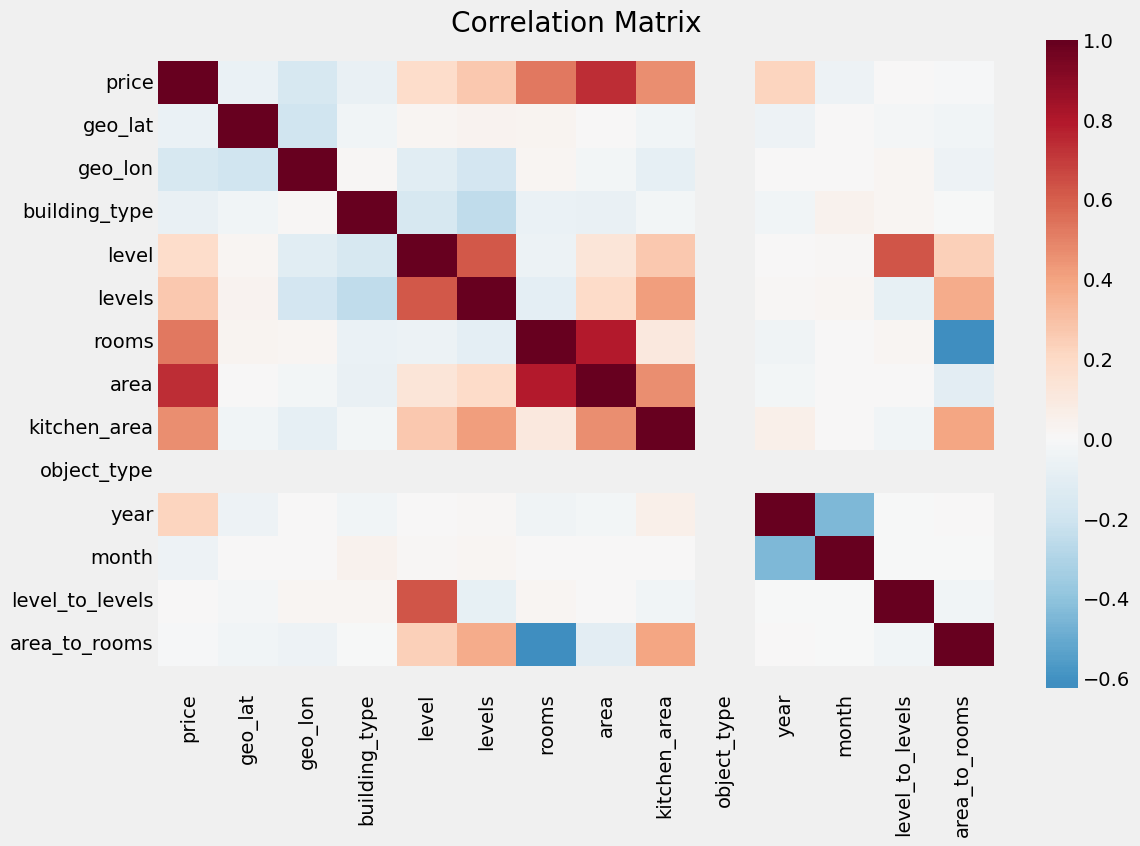

In [266]:
correlation = data.corr()
ax = sns.heatmap(correlation, center=0, cmap='RdBu_r')
l, r = ax.get_ylim()
ax.set_ylim(l + 0.5, r - 0.5)
plt.yticks(rotation=0)
plt.title('Correlation Matrix')
plt.show()

In [267]:
y = data.pop('price')

Models Cross-Validation

In [268]:
set_seed(SEED)

kf = KFold(N_FOLDS, shuffle=True, random_state=SEED)

XGBoost Model

In [269]:
scores = []

for train_index, test_index in kf.split(data, y):

    x_train, x_test = data.iloc[train_index, :], data.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model_xgb = XGBRegressor(objective='reg:squarederror')

    model_xgb.fit(x_train, y_train, eval_set=[(x_test, y_test)],
                  eval_metric='rmse', early_stopping_rounds=50,
                  verbose=0)

    scores.append(model_xgb.best_score)
    model_xgb.save_model(f'xgboost{len(scores)}.bin')

print('XGBoost average RMSE:', np.mean(scores))
for i, score in enumerate(scores):
    print(f'Model {i} RMSE: {score}')

XGBoost average RMSE: 1173733.8482429956
Model 0 RMSE: 1239332.1827156602
Model 1 RMSE: 1123007.04466807
Model 2 RMSE: 1197674.0786738254
Model 3 RMSE: 1145570.089026903
Model 4 RMSE: 1163085.8461305194


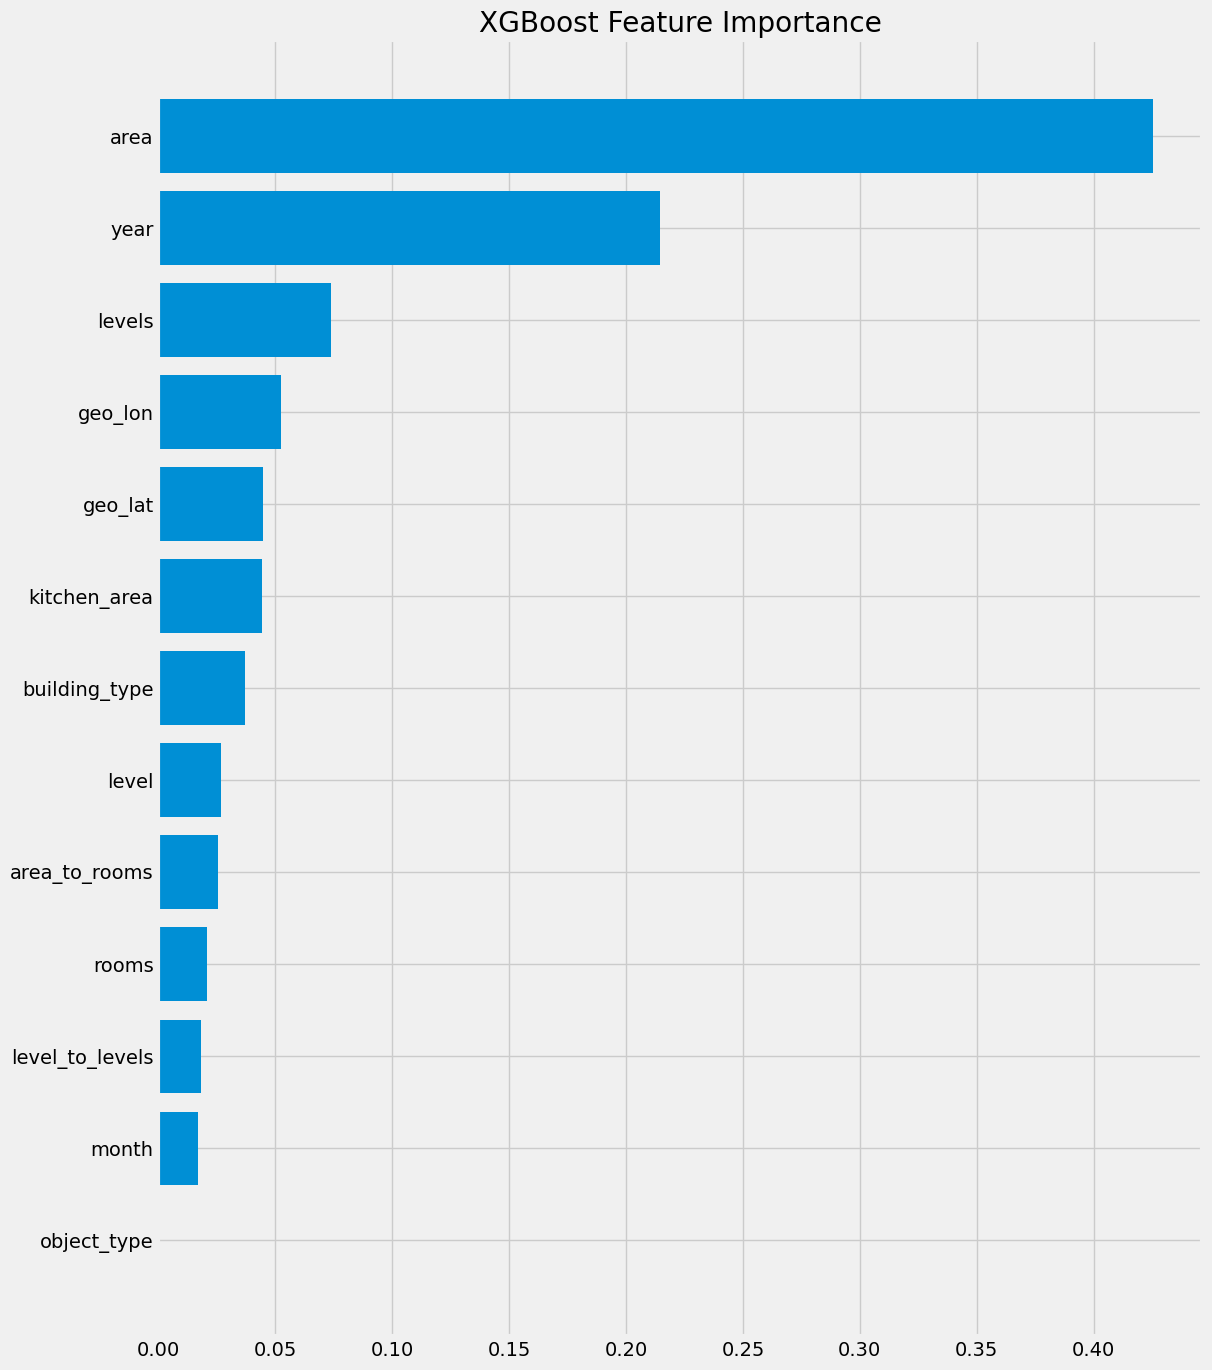

In [270]:
# Display feature importance.
importance = pd.DataFrame({
    'features': data.columns,
    'importance': model_xgb.feature_importances_
})
importance.sort_values(by='importance', inplace=True)

plt.figure(figsize=(12, 16))
plt.barh(importance['features'], importance['importance'])
plt.title('XGBoost Feature Importance')
plt.show()

LGMB Model

In [271]:
scores = []

for train_index, test_index in kf.split(data, y):

    x_train, x_test = data.iloc[train_index, :], data.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model_lgb = LGBMRegressor(objective='regression', metrics='rmse')

    model_lgb.fit(x_train, y_train, eval_set=(x_test, y_test),
                  eval_metric='rmse', early_stopping_rounds=50,
                  categorical_feature=['building_type', 'object_type', 'month'],
                  verbose=0)

    scores.append(model_lgb.best_score_['valid_0']['rmse'])
    model_lgb.booster_.save_model(f'lgbm{len(scores)}.txt',
                                  num_iteration=model_lgb.best_iteration_)

print('LGBM average RMSE:', np.mean(scores))
for i, score in enumerate(scores):
    print(f'Model {i} RMSE: {score}')

LGBM average RMSE: 1213719.1148944688
Model 0 RMSE: 1206399.56522601
Model 1 RMSE: 1217505.5163773333
Model 2 RMSE: 1195524.1380294133
Model 3 RMSE: 1238461.3643609895
Model 4 RMSE: 1210704.990478598


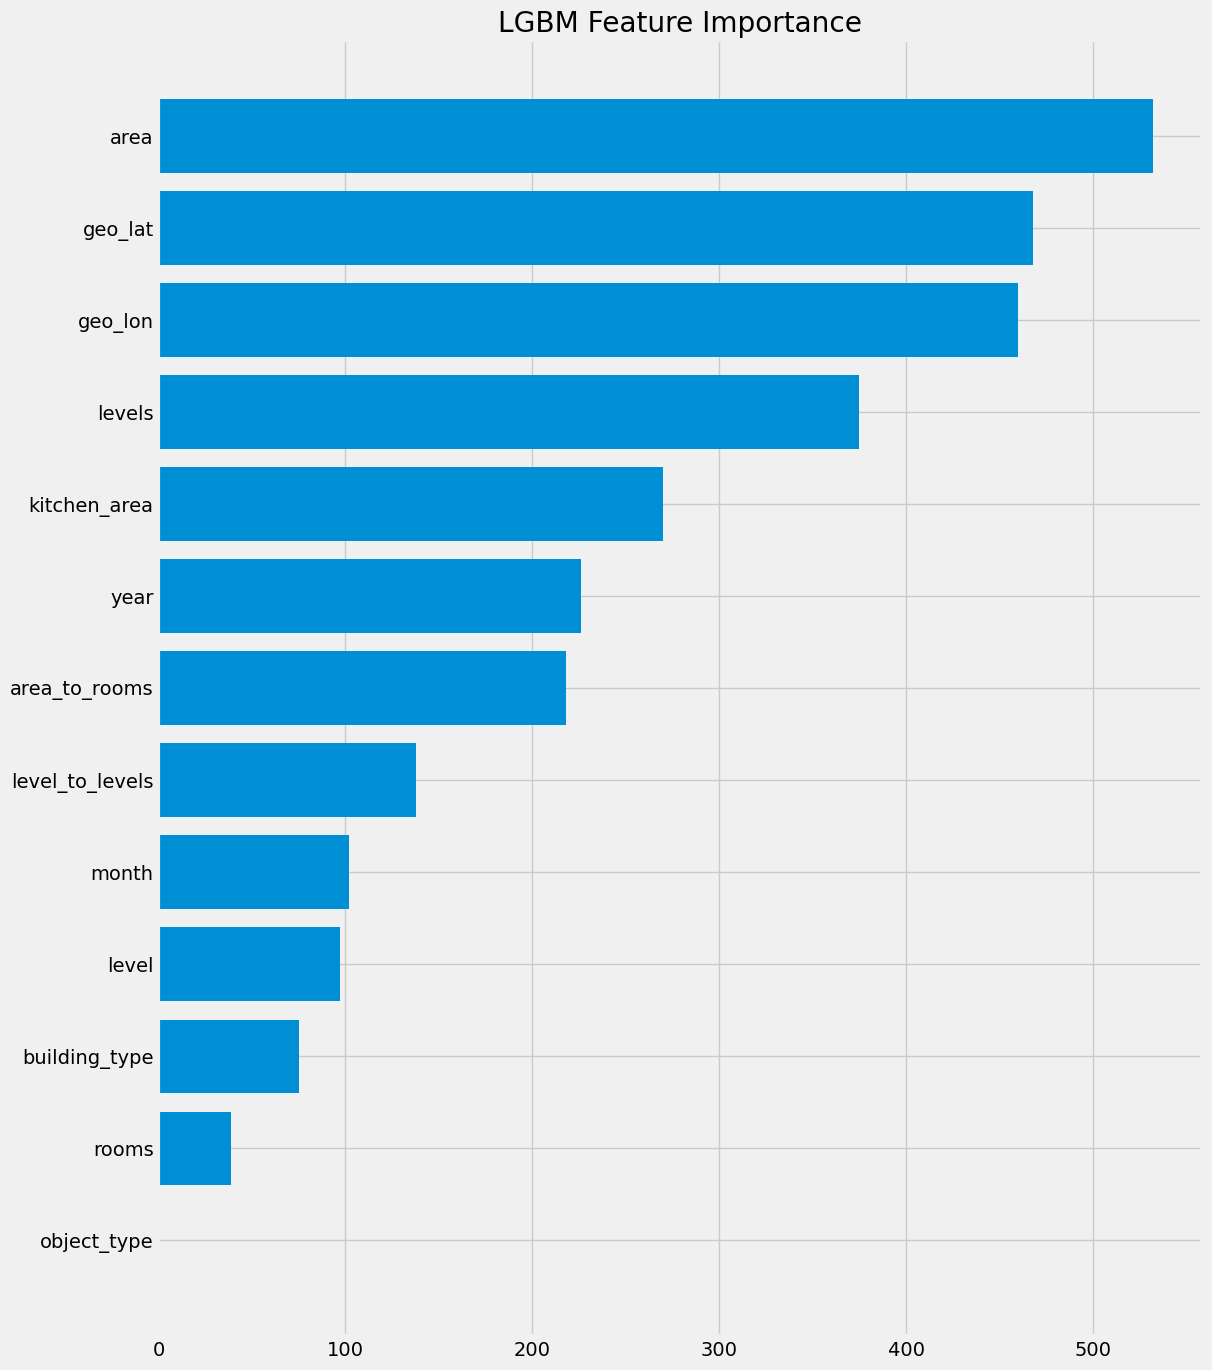

In [272]:
importance = pd.DataFrame({
    'features': data.columns,
    'importance': model_lgb.feature_importances_
})
importance.sort_values(by='importance', inplace=True)

plt.figure(figsize=(12, 16))
plt.barh(importance['features'], importance['importance'])
plt.title('LGBM Feature Importance')
plt.show()

Model test

In [273]:
d = {'geo_lat': [55.6883,55.8920], 
     'geo_lon': [37.5761,37.6003],
     'building_type': [3,3], 
     'level': [8,11],
     'levels': [8,12], 
     'rooms': [2,1],
     'area': [37,42.7], 
     'kitchen_area': [6,8.6],
     'object_type': [1,1], 
     'year': [6,6],
     'month': [4,9], 
     'level_to_levels': [1,0.92],
     'area_to_rooms': [18.5,42.7],
     'price':[17000000,10450000]}

d_y=d.pop('price')
example = pd.DataFrame(data=d)

In [274]:
test=model_xgb.predict(example)

In [275]:
test

array([12288758.,  7179706.], dtype=float32)

In [276]:
test2=model_lgb.predict(example)

In [277]:
test2

array([8689731.95807032, 7409707.34651403])

Digging down

In [140]:
df_a=data.join(y)

In [141]:
df_a.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16133 entries, 871611 to 5475801
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   geo_lat          16133 non-null  float64
 1   geo_lon          16133 non-null  float64
 2   building_type    16133 non-null  int64  
 3   level            16133 non-null  int64  
 4   levels           16133 non-null  int64  
 5   rooms            16133 non-null  int64  
 6   area             16133 non-null  float64
 7   kitchen_area     16133 non-null  float64
 8   object_type      16133 non-null  int64  
 9   year             16133 non-null  int64  
 10  month            16133 non-null  int64  
 11  level_to_levels  16133 non-null  float64
 12  area_to_rooms    16133 non-null  float64
 13  price            16133 non-null  int64  
dtypes: float64(6), int64(8)
memory usage: 2.4 MB


In [142]:
df_a.head()

,geo_lat,geo_lon,building_type,level,levels,rooms,area,kitchen_area,object_type,year,month,level_to_levels,area_to_rooms,price
871611,55.8949,37.4371,3,5,5,2,42.0000,5.5000,1,2019,1,1.0000,21.0000,4800000
875910,55.9141,37.8501,1,1,9,3,59.0000,6.9000,1,2019,1,0.1111,19.6667,4850000
876081,55.9077,37.7116,1,6,9,3,59.8000,7.0000,1,2019,1,0.6667,19.9333,6500000
876168,55.8756,37.4017,2,3,22,2,60.0000,16.0000,1,2019,1,0.1364,30.0000,6450000
876282,55.9025,37.4564,3,3,5,2,44.7000,5.4000,1,2019,1,0.6000,22.3500,5500000


In [147]:
df_price_by_month=df_a.groupby(['year','month']).agg({'price': ['mean']})

<AxesSubplot:>

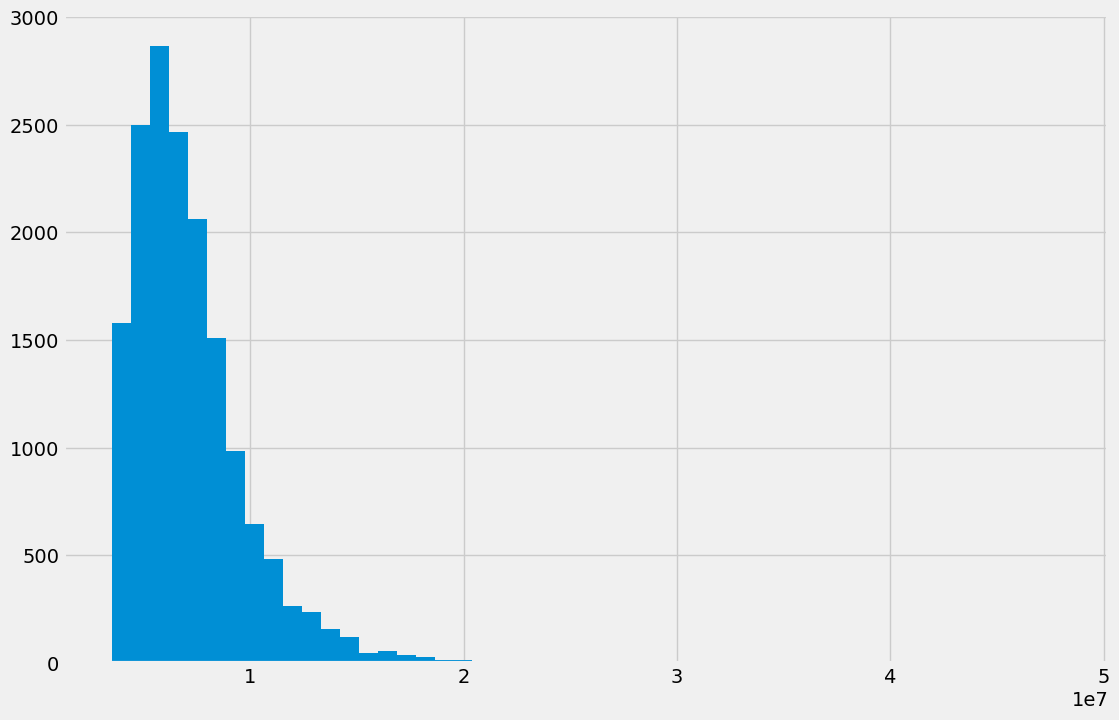

In [144]:
df_a['price'].hist(bins=50)

In [148]:
df_price_by_month

price
                    mean
year month              
2019 1      6519363.1997
     2      6630304.0677
     3      6689597.6521
     4      6698195.1969
     5      6660910.4456
     6      6568793.0670
     7      6836337.0990
     9      6827883.8031
     10     6787899.8698
     11     6689114.1241
     12     6953587.6426
2020 1      6909430.9493
     2      6806091.5880
     3      6851551.6132
     4      7065782.3088
     5      7272355.5909
     6      7014467.5506
     7      7153348.3534
     9      7493648.8215
     10     7515718.7509
     11     7647144.4485
     12     7866856.1003
2021 1      7778305.1228
     2      8597171.8643
     3      8770793.9245
     4      9001015.7768
     5     10171528.1818